In [274]:
# load library
import scipy.io
import scipy.ndimage
import numpy as np
import matplotlib.pyplot as plt

IMAGE_FOLDER = './RaoBallardImages/'

# load the .mat file in the folder, shape is (512, 512, 10) which is (height, width, number of images)
images = scipy.io.loadmat(IMAGE_FOLDER + 'IMAGES_RAW.mat')['IMAGESr']

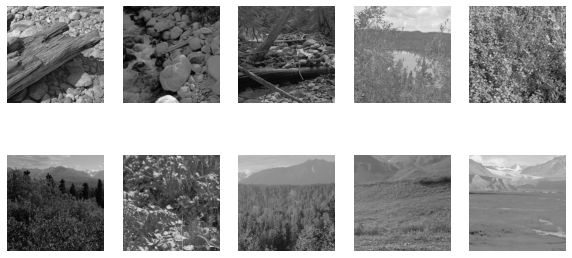

In [275]:
# load the images in a grid, 2 rows of 5 images
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(images[:, :, i*5+j], cmap='gray')
        ax[i, j].axis('off')

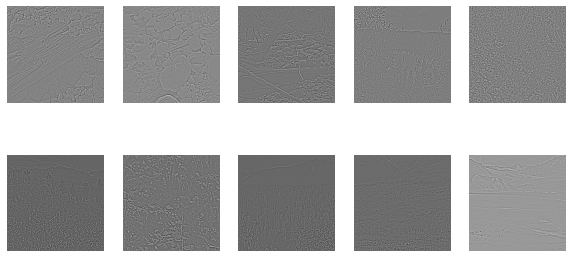

In [277]:
# a difference of guasians filter
def dog_filter(image, sigma1, sigma2):
    # calculate the difference of gaussian
    dog = scipy.ndimage.gaussian_filter(image, sigma1) - scipy.ndimage.gaussian_filter(image, sigma2)
    return dog

# apply the filter to the images, and call them filt_imgs
filt_imgs = np.zeros(images.shape)
for i in range(images.shape[2]):
    filt_imgs[:, :, i] = dog_filter(images[:, :, i], 1.3, 1.6)

# plot the filtered images
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(filt_imgs[:, :, i*5+j], cmap='gray')
        ax[i, j].axis('off')

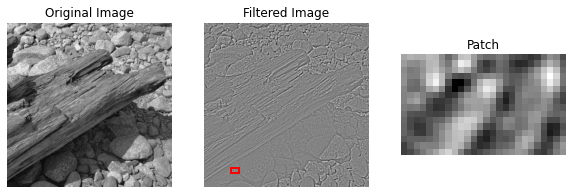

In [278]:
# get a random 32 by 128 patch from the imag
def get_random_patch(image, patch_size=(16, 26)):
    # get the height and width of the image
    height, width = image.shape
    # get the height and width of the patch
    patch_height, patch_width = patch_size
    # get a random start point for the patch
    start_height = np.random.randint(0, height - patch_height)
    start_width = np.random.randint(0, width - patch_width)
    # get the patch
    patch = image[start_height:start_height+patch_height, start_width:start_width+patch_width]
    # return the patch and the rectangle of the patch
    return patch, (start_height, start_width, start_height+patch_height, start_width+patch_width)

# get a random patch from a filtered image and then plot the original image, the filtered image, and the patch
def plot_random_patch(image, filt_image, patch_size=(16, 26)):
    # get the patch and the rectangle of the patch
    patch, rect = get_random_patch(filt_image, patch_size)
    # get the height and width of the patch
    patch_height, patch_width = patch_size
    # get the height and width of the image
    height, width = image.shape
    # get the start and end points of the patch
    start_height, start_width, end_height, end_width = rect
    # plot the original image, the filtered image, and the patch
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(image, cmap='gray')
    ax[0].axis('off')
    ax[0].set_title('Original Image')
    ax[1].imshow(filt_image, cmap='gray')
    ax[1].axis('off')
    ax[1].set_title('Filtered Image')
    ax[1].add_patch(plt.Rectangle((start_width, start_height), patch_width, patch_height, fill=False, edgecolor='red', linewidth=2))
    ax[2].imshow(patch, cmap='gray')
    ax[2].axis('off')
    ax[2].set_title('Patch')

    # return the patch and the rectangle of the patch
    return patch, rect

# plot a random patch from the first filtered image
patch, rectangle = plot_random_patch(images[:, :, 0], filt_imgs[:, :, 0])

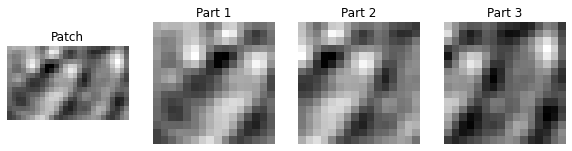

In [279]:
# take the patch and seperate it into 3, 16 by 16 parts, offset by 5 pixels horizontally
def get_patch_parts(patch):
    # get the height and width of the patch
    height, width = patch.shape
    # get the height and width of the parts
    part_height, part_width = 16, 16
    # get the offset of the parts
    offset = 5
    # get the parts
    part1 = patch[:part_height, :part_width]
    part2 = patch[:part_height, offset:offset+part_width]
    part3 = patch[:part_height, offset*2:offset*2+part_width]
    # return the parts
    return part1, part2, part3


# seperate the patch into 3 parts and plot the parts
parts = get_patch_parts(patch)

# plot the patch, then plot the parts
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
ax[0].imshow(patch, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Patch')
for i in range(3):
    ax[i+1].imshow(parts[i], cmap='gray')
    ax[i+1].axis('off')
    ax[i+1].set_title('Part ' + str(i+1))


SyntaxError: invalid syntax (1970196125.py, line 1)

In [411]:
import torch
import torch.nn as nn

# define a torch module for a single patch
class PredictiveCodingLevel(nn.Module):
    def __init__(self, num_pixels, num_causes, k1, k2, sigma, alpha, lam):
        super(PredictiveCodingLevel, self).__init__()
        self.num_pixels = num_pixels # number of pixels in the image
        self.num_causes = num_causes # number of causes
        self.k1 = k1 # learning rate for r
        self.k2 = k2 # learning rate for U
        self.sigma = sigma # noise level
        self.alpha = alpha # weight on the r prior
        self.lam = lam # weight on U prior
        self.U = nn.Parameter(torch.rand(size=(num_pixels, num_causes)))
        # do xavier initialization on U
        nn.init.xavier_uniform_(self.U)
        self.r = nn.Parameter(torch.zeros(size=(num_causes, 3)))
        #self.f = torch.tanh
        # define f to be the identity function
        self.f = lambda x: x
        self.precision = 1/(sigma**2)
        self.U_prior = torch.norm
        self.r_prior = torch.norm
        # define a function that takes in a torch tensor and returns sum(log(1+x_i^2)) where the sum is over all elements of the tensor
        #self.r_prior = lambda x: torch.sum(torch.log(1 + x**2)) 
        #self.U_prior = lambda x: torch.sum(torch.log(1 + x**2)) 

        # these are for bookkeeping
        self.prediction = None
        self.prediction_error = None
        self.prediction_loss = None
        self.U_prior_loss = None
        self.r_prior_loss = None
        self.total_loss = None

    def forward(self, x):
        # x is the input "image" which is a torch tensor of size (num_images, num_pixels)
        # get the prediction, which is U*r 
        # U is of size (num_pixels, num_causes) and r is of size (num_causes, num_images)
        prediction = torch.matmul(self.U, self.r).T
        # print the shape of U, r, and prediction, descriptively, and also what they should be
        # print('U shape: {}, r shape: {}, prediction shape: {}'.format(self.U.shape, self.r.shape, prediction.shape))
        # print('U should be of shape (num_pixels, num_causes), r should be of shape (num_causes, num_images), prediction should be of shape (num_pixels, num_images)')
        # print('the shape of x is: {}'.format(x.shape))
        prediction_error = x - prediction
        prediction_loss = self.precision*torch.norm(prediction_error)**2
        U_prior_loss = self.lam*self.U_prior(self.U)
        r_prior_loss = self.alpha*self.r_prior(self.r)

        # update internal values
        self.prediction = prediction
        self.prediction_error = prediction_error
        self.prediction_loss = prediction_loss
        self.U_prior_loss = U_prior_loss
        self.r_prior_loss = r_prior_loss
        self.total_loss = prediction_loss + U_prior_loss + r_prior_loss

        # we want to return r, but we need to flatten and concat it
        # so that it is of size (num_causes*num_images, 1)

        r_return = self.r.flatten().view(1, -1)
        # print('r_return shape: {}'.format(r_return.shape))

        return r_return

torch.Size([3, 256])
Iteration:    0 | Batch:    0 | Loss:    0.37777 | U max:    0.14429 | r max:    0.00485
Iteration: 1000 | Batch:    0 | Loss:    0.40601 | U max:    0.12430 | r max:    0.02190
Iteration: 2000 | Batch:    0 | Loss:    0.34271 | U max:    0.09236 | r max:    0.01621
Iteration: 3000 | Batch:    0 | Loss:    0.30511 | U max:    0.07509 | r max:    0.01754
Iteration: 4000 | Batch:    0 | Loss:    0.28064 | U max:    0.06185 | r max:    0.01841
Iteration: 5000 | Batch:    0 | Loss:    0.26299 | U max:    0.05264 | r max:    0.02027
Iteration: 6000 | Batch:    0 | Loss:    0.25184 | U max:    0.04579 | r max:    0.01826
Iteration: 7000 | Batch:    0 | Loss:    0.24409 | U max:    0.04139 | r max:    0.02620
Iteration: 8000 | Batch:    0 | Loss:    0.23881 | U max:    0.03821 | r max:    0.02093
Iteration: 9000 | Batch:    0 | Loss:    0.23516 | U max:    0.03605 | r max:    0.01934
torch.Size([3, 256])
Iteration:    0 | Batch:    1 | Loss:    0.29306 | U max:    0.03453

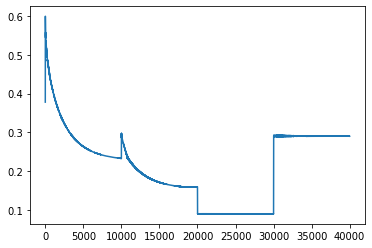

In [412]:
# we have 3 16x16 patches per image so in total we have 
num_pixels = 16*16
# we will make a two layer model, with 32 causes in the first layer
# and 96 in the second layer
model = nn.Sequential(PredictiveCodingLevel(num_pixels, 32, k1=.3, k2=.2, sigma=np.sqrt(1), alpha=1, lam=0.02),
                        PredictiveCodingLevel(32*3, 128, k1=.3, k2=.2, sigma=np.sqrt(10), alpha=0.05, lam=0.02))

batch_size = 4

eps = 1e-3

def GaussianMask(sizex=16, sizey=16, sigma=5):
    x = np.arange(0, sizex, 1, float)
    y = np.arange(0, sizey, 1, float)
    x, y = np.meshgrid(x,y)
    
    x0 = sizex // 2
    y0 = sizey // 2
    mask = np.exp(-((x-x0)**2 + (y-y0)**2) / (2*(sigma**2)))
    return mask / np.sum(mask)

gmask = GaussianMask()
# normalize gmask to be between 0 and 1
gmask = (gmask - np.min(gmask)) / (np.max(gmask) - np.min(gmask))

# for each image in the batch, run the model for 1000 timesteps
loss_list = []
for i in range(batch_size):
    # get a random image from filt_imgs
    img = filt_imgs[:,:,np.random.randint(0,filt_imgs.shape[2])]

    # get a random patch from the image
    patch, _ = get_random_patch(img, patch_size=(16,26))

    # compute the mean pixel value for the patch and subtract it from the patch
    # also normalize so that the pixel values have a standard deviation of 1
    patch = patch - np.mean(patch)

    # convert the patch to parts
    parts = get_patch_parts(patch)

    # apply the gaussian mask to each part
    parts = [part*gmask for part in parts]
    
    # flatten the parts
    parts = [part.flatten() for part in parts]

    # make into a torch tensor
    patch = torch.tensor(parts, dtype=torch.float32) # (num_parts, num_pixels)

    # print patch shape
    print(patch.shape)
    
    # reset k2 to the original value
    model[0].k2 = .2
    model[1].k2 = .2
    

    # run the model for 1000 timesteps
    for t in range(10000):
        output = model(patch)


        #  define loss as the sum of total loss from all layers of the model
        loss = sum([layer.total_loss for layer in model])

        loss_list.append(loss.item())

        #backpropagate the loss
        loss.backward()

        # compute the gradients with respect to U and r for each layer
        U_gradients = [layer.U.grad for layer in model]
        r_gradients = [layer.r.grad for layer in model]

        # if there are any nans in the gradients, print out the iteration number
        # we have to make sure the list of torch arrays in U_gradients and r_gradients
        # are treated correctly
        if any([torch.isnan(r).any() for r in r_gradients]):
            print("r gradient has nans at iteration {}".format(t))
            break
        if any([torch.isnan(U).any() for U in U_gradients]):
            print("U gradient has nans at iteration {}".format(t))
            break
        
        # we want to compute the norm of the updates to U and r
        # we update U by k2/2*U_grad
        # we update r by k1/2*r_grad
        # we want to keep track of the U andr updates

        U_ups, r_ups = [], []
        for layer in model:

            U_update= -layer.k2/2*layer.U.grad
            r_update = -layer.k1/2*layer.r.grad

            U_ups.append(U_update)
            r_ups.append(r_update)

            layer.U.data += U_update
            layer.r.data += r_update

        # compute the norm of the updates
        # concatenate the updates into a single tensor
        # and then compute the norm
        U_norm = torch.norm(torch.cat([U_update.flatten() for U_update in U_ups]))
        r_norm = torch.norm(torch.cat([r_update.flatten() for r_update in r_ups]))

        # if either of the norms is smaller than eps, print out the iteration number
        # and go to the next i
        if U_norm < eps and r_norm < eps:
            print("norm is small at iteration {}".format(t))
            break

        # zero out the gradients for the entire model
        model.zero_grad()
        
        # every 10 iterations, print out the loss
        # but also print out the iteration, the batch number, and the abs max of U and r
        # and keep it very neat
        if t % 1000 == 0:
            print("Iteration: {:4d} | Batch: {:4d} | Loss: {:10.5f} | U max: {:10.5f} | r max: {:10.5f}".format(t, i, loss.item(), model[0].U.max().item(), model[0].r.max().item()))
            # also add in the U and r losses
            #print("U prior loss: {:10.5f} | r prior loss: {:10.5f} | prediction loss: {:10.5f}".format(model[0].U_prior_loss.item(), model[0].r_prior_loss.item(), model[0].prediction_loss.item()))
        # every 40 iterations, divide k2 by 1.015
        if t % 40 == 39:
            for layer in model:
                layer.k2 /= 1.015



plt.plot(loss_list)
    
    

[tensor(0.0301), tensor(0.0200)]

In [413]:
# # get U from the first level
# U = model[0].U.detach().numpy()
U = model[0].U.detach().numpy()

# get the first column of U
U1 = U[:,0]

# print the shape of U1
print(U1.shape)

# get the first third of U1
U1_1 = U1[:U1.shape[0]//3]

# now reshape U1_1 to be 16x16
U1_1 = U1_1.reshape(16,16)

# plot U1_1
plt.imshow(U1_1)




# look at the Gaussian mask
plt.imshow(GaussianMask())

# print the mean max min and std of gmask
print(np.mean(gmask), np.max(gmask), np.min(gmask), np.std(gmask))


(256,)


ValueError: cannot reshape array of size 85 into shape (16,16)

ValueError: cannot reshape array of size 256 into shape (3,16,16)

<Figure size 1440x1440 with 0 Axes>

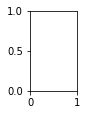

In [414]:
# plot the first 5 columns of U, each in its own subplot
# each column of U should be reshaped to be 3 different 16x16 patches
# and each of the 3 patches should be plotted in its own subplot
# make the figure bigger
U = model[0].U.detach().numpy()
plt.figure(figsize=(20,20))
num_cols = 20
num_rows = 3
# make a figure with subplots num_rows rows and num_cols columns
# each subplot should be 16x16
# each column of U should be reshaped to be 3 different 16x16 patches
# and each of the 3 patches should be plotted in its own column
# make the figure a good size
# take out all axes labels
plt.figure(figsize=(20,5))
for i in range(num_cols):
    for j in range(num_rows):
        plt.subplot(num_rows, num_cols, i*num_rows + j + 1)
        # plot in grayscale
        plt.imshow(U[:,i].reshape(3,16,16)[j,:,:], cmap='gray')
        plt.axis('off')

# now do that for the first 10 columns of Uh
# and plot them in a 2x5 grid
plt.figure(figsize=(20,10))
num_cols = 10
num_rows = 3
# make a figure with subplots num_rows rows and num_cols columns
# each subplot should be 16x16
# make the figure a good size
# take out all axes labels
# every subplot should be a linear combination of the lower level U columns
plt.figure(figsize=(20,5))
for i in range(num_cols*num_rows):
    plt.subplot(num_rows, num_cols, i + 1)
    # plot in grayscale
    # get lower level U
    Ul = model[0].U.detach().numpy()
    # get a single column of the higher level U
    Uh1 = Uh[:,i]
    # now take the linear combination of the lower level U columns according to the weights in the higher level U columns
    rf_h = np.dot(Ul, Uh1)
    # reshape the rf_h to be 3 16x16 patches
    rf_h = rf_h.reshape(3,16,16)
    # the 3 patches overlap, so we can combine into one single image, they have a stride of 5 horizontal
    rf_h = np.concatenate([rf_h[0,:,:], rf_h[1,:,11:], rf_h[2,:,-6:]], axis=1)
    plt.imshow(rf_h, cmap='gray')
    plt.axis('off')

(256, 32) (96, 128)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


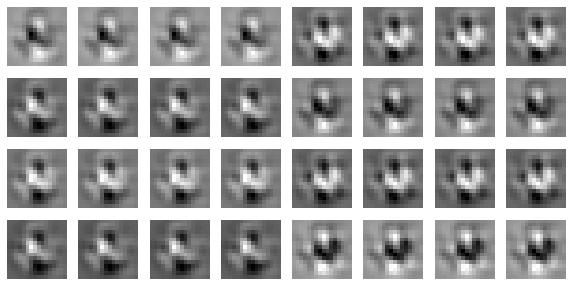

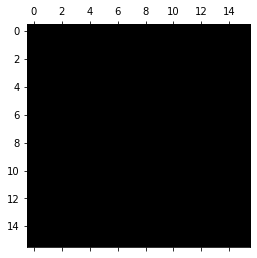

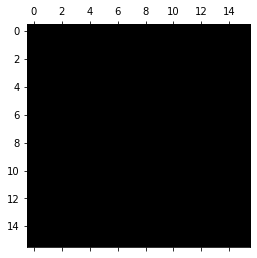

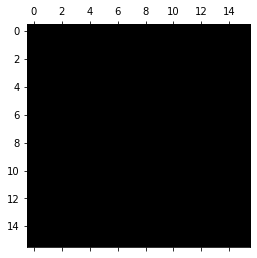

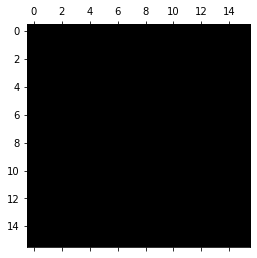

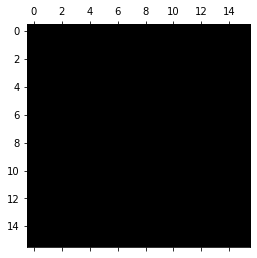

In [429]:
U = model[0].U.detach().numpy() # get the first level U
Uh = model[1].U.detach().numpy() # get the second level U

# PRINT shape of U and Uh
print(U.shape, Uh.shape)

# each column of U should be reshaped to be a 16 by 16 patch, and should be plotted
# in a 8x4 grid
plt.figure(figsize=(10,5))
num_cols = 8
num_rows = 4
for i in range(num_cols):
    for j in range(num_rows):
        plt.subplot(num_rows, num_cols, i*num_rows + j + 1)
        plt.imshow(U[:,i].reshape(16,16), cmap='gray')
        plt.axis('off')

# make a for loop across the columns of Uh
for i in range(5):
    # get a single column of Uh
    Uh1 = Uh[:,i] # shape is 96
    # reshape to be 3 16x16 patches
    Uh1 = Uh1.reshape(-1,3) # shape is 3x32
    result = np.dot(U, Uh1) # (256,32) (32,3) = (256,3)\
    # reshape to be 3 16x16 patches
    result = result.reshape(16,16,3)
    # now we need to combine these patches with 5 pixel horizontal offset
    for j in range(1,3):
        result[:,5*j:,:] += result[:,:-5*j,:]

    # plot the result
    plt.matshow(result, cmap='gray')


In [430]:
result

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.03674241e-14,  7.37343133e-16,  4.07477363e-14],
        [ 5.24994172e-14, -2.88669210e-15,  1.90852176e-13],
        [ 1.16657403e-13, -1.06615664e-14,  4.14116766e-13],
        [ 1.19748707e-13, -1.10040015e-14,  4.25049427e-13],
        [-3.46660533e-14,  4.66259958e-15, -1.19576603e-13],
        [-2.07413256e-13,  2.46901007e-14, -7.23045593e-13],
        [-2.69158583e-13,  4.49270443e-14, -9.08310916e-13],
        [-2.25937826e-13,  3.80159737e-14, -7.61650942e-13],
        [-2.28166769e-13,  3.52852140e-14, -7.76155941e-13],
        [-2.39337087e-13,  1.40741470e-14, -8.67791787e-13],
        [-2.49681488e-13,  7.20475319e-16, -9.38031770e-13],
        [-2.34568549e-13,  1.18062163e-14, -8.55363360e-13],
        [-1.93449030e-13,  1.08238461e-14, -7.02800882e-13],
        [-2.20271867e-13,  2.05773814e-14, -7.80718480e-13],
        [-2.48600077e-13,  1.17714854e-14, -9.08021488e-13]],

       [[ 1.12550867e-